# Библиотеки

In [1]:
# Проверка версии и пути к выбранному интерпретатору
import sys
print(f"Версия Python - {sys.version}")
print(f"Путь к интерпретатору Python - {sys.executable}")

Версия Python - 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
Путь к интерпретатору Python - C:\Programs\Python39x64\python.exe


In [2]:
# Python 3.10
import pandas as pd
import numpy  as np
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

%matplotlib inline
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.graph_objects as go

In [3]:
import tensorflow as tf
from   tensorflow.keras import layers, activations, losses, optimizers, metrics # импорт для более короткой записи

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(False)
#tf.config.set_soft_device_placement(False)

Num GPUs Available:  0


In [5]:
# Проверка версий библиотек
for lib in [pd, np, sklearn, tf]:
    print(f"{lib.__name__:<12} {lib.__version__}")

pandas       2.1.1
numpy        1.24.3
sklearn      1.3.1
tensorflow   2.12.1


In [6]:
import time

- - - - -

# Вспомогательные функции
Определим вспомогательную функции для вывода изображений и вычислений модели

In [7]:
def imshowWithAnnotValue(dataImage):
    """
    Отображает черно-белое изображение с просмотром значений пикселей
        - dataImage: матрица значений пикселей
    """
    # Вывод изображения
    maxVal =  dataImage.max()
    minVal =  dataImage.min()
    rangeVal = maxVal - minVal
    print(minVal, maxVal, rangeVal)

    plt.figure(figsize=(10,10)) # создать полотно для рисования, figsize-размер в дюймах
    shw = plt.imshow(# отобразить массив как изображение
        X=dataImage, # данные
        cmap="gray",  # название цветовой шкалы
        vmin=minVal, vmax=maxVal, # границы цветовой шкалы
        interpolation=None, filternorm=True # отключить сглаживание и размытие
    )
    plt.grid(False)
    bar = plt.colorbar(shw) # отобразить цветовую шкалу

    ax = plt.gca()
    nrow = dataImage.shape[0]
    ncol = dataImage.shape[1]

    # Нанести подписей значений для каждого элемента
    for i in range(nrow):
        for j in range(ncol):
            if dataImage[i, j] > 0.3*(rangeVal+minVal):  myColor = "black"
            else:     myColor = "white"
            #print (i, j, myColor, dataImage[i, j])

            text = ax.text(j, i,
                           f"{dataImage[i, j]:.0f}" if maxVal>1 else f"{dataImage[i, j]:.1f}",
                           ha="center", va="center", color=myColor, fontweight="normal", fontsize=7)
    plt.show()  # отрисовать содержимое полотна

In [8]:
def calcAndPlotConfusionMatrix (y_test_all_labels, y_pred_all_labels, class_names=None):
    """
    Вычисляет и отображает графически матрицу ошибок
        - y_test_all_labels,  # ожидаемые/проверочные метки классов
        - y_pred_all_labels,  # вычисленные метки классов
        - class_names,        # список названий классов

    """

    # Создать матрицу ошибок как массив
    cm = tf.math.confusion_matrix(
        labels      =y_test_all_labels,  # ожидаемые/проверочные метки классов
        predictions =y_pred_all_labels,  # вычисленные метки классов
    ).numpy()
    cmStr = cm.astype('str') # представить значения как строки
    cmStr [cmStr =='0'] = '' # убрать нули

    print(cm)
    # Отобразить матрицу ошибок в графическом виде
    plt.figure(figsize=[5,5])
    ax= sns.heatmap(
                data=cm, # Матрица значений
                cmap="rocket_r", # Цветовая палитра. crest viridis_r rocket_r
                #annot=True,  fmt='d',
                annot=cmStr,  fmt='s', # Подписи в ячейках матрицы
                annot_kws={"size": 10}, square = True)
    ax.set_xlabel('Вычисленный класс')
    ax.set_ylabel('Ожидаемый класс')
    ax.set_title(f'Матрица ошибок. {len(totalHistoryLossTrain)} эпох')
    if class_names!=None:
      ax.set_xticklabels(class_names)
      ax.set_yticklabels(class_names)
    plt.xticks(rotation=70)
    plt.yticks(rotation=0)
    plt.show()

In [9]:
def checkPrediction(  model,  imagesArray, labelsArray, indexOfImages):
    '''
    Решение случайного образца из data_loader указанной моделью
        - model - обученая модель
        - imagesArray - массив numpy с множеством изображений
        - labelsArray - массив numpy с номерами истинных меток классов
        - indexOfImages - порядковый номер выбранного изображения в imagesArray
    '''
    # Получить одиночное изображение по индексу
    img = imagesArray[indexOfImages]

    # Получить истинную метку класса
    y_true_prob  = labelsArray[indexOfImages] # Вероятности каждого класса
    y_true_label = np.argmax(y_true_prob)    # Номер макс. вероятного класса

    # Получить ответ модели
    y_pred_prob  = model( np.expand_dims(img, axis=0) ) # Вероятности каждого класса
    y_pred_label = np.argmax(y_pred_prob)              # Номер макс. вероятного класса

    # Графики ---------------------------------
    f, (ax1, ax2) = plt.subplots(figsize=(7,3), nrows= 1, ncols= 2,  )

    # График. Вывести исходное изображение
    ax1.imshow(img, cmap="gray")
    ax1.set_title("Исходное изображение")

    # График. Вывести вероятности принадлежности
    barColors=['black'] * len(class_names)
    barColors[y_pred_label] = "#cd3232"    # предпологаемый класс - красный (orangered, #cd3232)
    barColors[y_true_label] = "limegreen" # истинный класс - зелёный

    y_pos  = np.arange(len(class_names))
    ax2.barh( y=y_pos, width=y_pred_prob.numpy()[0], color=barColors, height = 0.8)
    ax2.set_yticks(y_pos, labels=class_names)
    ax2.set_title("Вероятность принадлежности к каждому классу")
    ax2.bar_label( ax2.containers[0], fmt='%.2f')
    ax2.invert_yaxis()
    ax2.set_xlim([0.0, 1.0])

    # Отобразить графики
    plt.tight_layout()
    plt.show()

    # Текстовая информация ---------------------------------
    print(f"Класс (метка):")
    print(f"  - Истинный    TRUE_Label = {y_true_label} {class_names[y_true_label]}")
    print(f"  - Вычисленный PRED_Label = {y_pred_label} {class_names[y_pred_label]}")
    print('Вероятность принадлежности к каждому классу:')
    for i, probability in enumerate(y_pred_prob[0]):
        print(f'  - Класс_{i} {class_names[i]:>12} : {probability:>5.1%}' ,end='')
        if i==y_pred_label and y_true_label!=y_pred_label:  print(' !!!Ошибка!!!',end='')
        print()

- - -

# Подготовка данных

## Загрузка данных FashionMNIST

<div style="max-height:200px;  ">
    
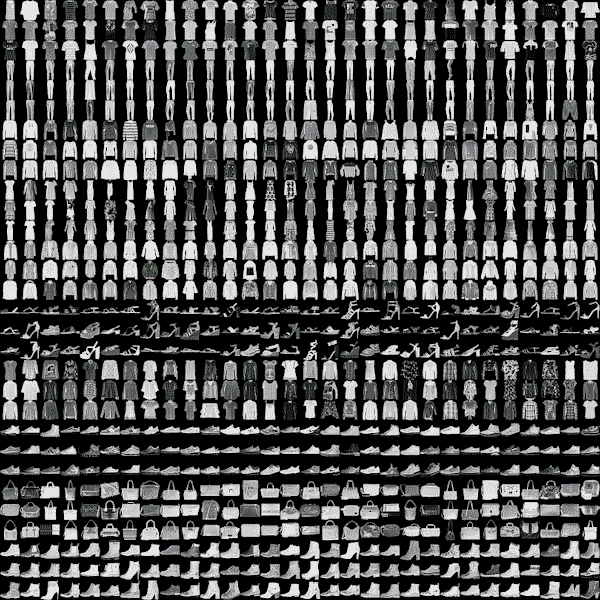
</div>

In [10]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### Размер выборки

In [11]:
# --------------------------------------------------
print('Тип данных структуры train_images ', type(train_images))
print('Тип данных структуры train_labels ', type(train_labels))

print('\nСостав:')
print('  - обучающего   набора изображений:', train_images.shape)
print('  - проверочного набора изображений:', test_images.shape)
print('  - обучающего   набора меток:', train_labels.shape)
print('  - проверочного набора меток:', test_labels.shape)

Тип данных структуры train_images  <class 'numpy.ndarray'>
Тип данных структуры train_labels  <class 'numpy.ndarray'>

Состав:
  - обучающего   набора изображений: (60000, 28, 28)
  - проверочного набора изображений: (10000, 28, 28)
  - обучающего   набора меток: (60000,)
  - проверочного набора меток: (10000,)


In [12]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [13]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [14]:
print('\nУникальных классов:', np.unique(test_labels))


Уникальных классов: [0 1 2 3 4 5 6 7 8 9]


In [15]:
class_names = ['T-shirt/top', # Футболка/топ
               'Trouser',     # Брюки
               'Pullover',    # Пуловер/джемпер
               'Dress',       # Платье
               'Coat',        # Плащь/пальто
               'Sandal',      # Сандалии
               'Shirt',       # Рубашка/сорочка
               'Sneaker',     # Кроссовки
               'Bag',         # Сумка
               'Ankle boot'   # Обувь с высоким берцем
              ]

[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


Text(0.5, 1.0, 'Кол-во каждого представителя класса')

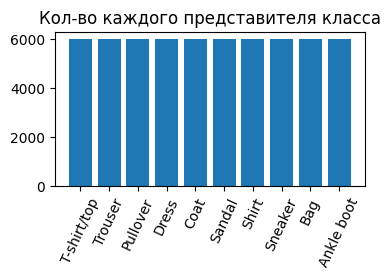

In [16]:
clNum , counts = np.unique(train_labels, return_counts=True)

print(counts)
plt.figure(figsize=(4,2))
plt.bar(class_names, counts)
plt.xticks(rotation=65)
plt.title("Кол-во каждого представителя класса")

### Просмотр случайного образца

In [17]:
# Случайный индекс от 0 до размера тренировочной выборки
indexOfImgs = np.random.randint(low=0, high=train_images.shape[0])

# Получить черно-белое изображение, как массив значений яркости пикселей
dataImage = train_images[indexOfImgs]

# Получить истинную метку - принадлежность изображение к одному из 10 классов
y_true= train_labels[indexOfImgs]

In [18]:
print ("Номер изображения:    ", indexOfImgs  )
print ("Размер изображения:   ", dataImage.shape  )
print ("Истинный класс y_true:", y_true, class_names[y_true], )

Номер изображения:     11946
Размер изображения:    (28, 28)
Истинный класс y_true: 7 Sneaker


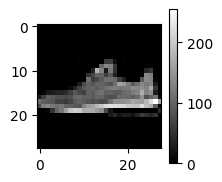

In [19]:
# Вывод изображения в простой форме
plt.figure(figsize=(2,2))  # создать полотно для рисования, figsize-размер в дюймах
shw = plt.imshow(# отобразить массив как изображение
    X=dataImage,  # данные
    cmap="gray",  # название цветовой шкалы
    interpolation=None, filternorm=True # отключить сглаживание и размытие
)
plt.grid(False)
bar = plt.colorbar(shw) # отобразить цветовую шкалу
plt.show()  # отрисовать содержимое полотна

0 255 255


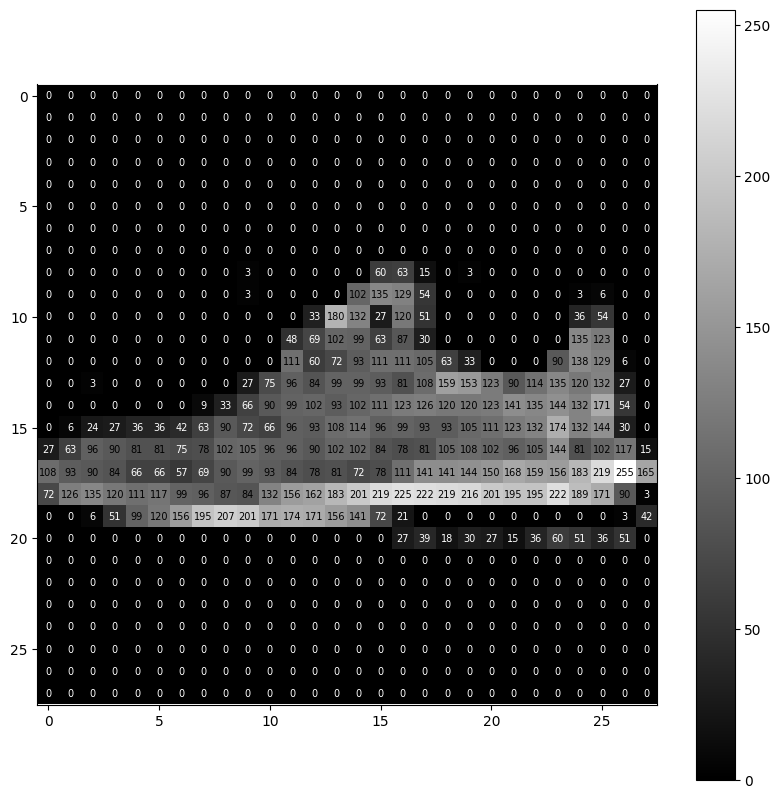

In [20]:
imshowWithAnnotValue(dataImage)

## Модификация значений

In [21]:
train_images = train_images.astype('float32')
test_images  = test_images.astype('float32')

train_images = train_images / 255.0
test_images  = test_images  / 255.0

In [22]:
train_images[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

## Кодирование меток классов "one-hot encoded"

In [23]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [24]:
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [25]:
print('\nУникальных классов:', np.unique(train_labels))
print('\nУникальных классов:', np.unique(test_labels))


Уникальных классов: [0 1 2 3 4 5 6 7 8 9]

Уникальных классов: [0 1 2 3 4 5 6 7 8 9]


In [26]:
train_labels =  tf.keras.utils.to_categorical(train_labels)
test_labels  =  tf.keras.utils.to_categorical(test_labels)

print("train_labels", '\n  Изображений образцов', train_labels.shape[0], '\n  Столбцов-индикаторов для каждого класса', train_labels.shape[1])
print(train_labels)
print()
print("test_labels"'\n  Изображений образцов', test_labels.shape[0], '\n  Столбцов-индикаторов для каждого класса', test_labels.shape[1])
print(test_labels)

train_labels 
  Изображений образцов 60000 
  Столбцов-индикаторов для каждого класса 10
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

test_labels
  Изображений образцов 10000 
  Столбцов-индикаторов для каждого класса 10
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#

В свёрточных нейронных сетях используются дополнительные слои для понижения размерности исходной матрицы признаков (разрешения изображения). Понижение размерности проводится повторяется многократно, но выполняется двумя видами операций:
- свёртки (convolution)
- объединения (пулинга, pooling)

Группа слоёв свёртки и объединения носит название блока выделения признаков из изображения, т.к. значительно понижает кол-во пикселей, при этом обеспечивает возможность различать исходные изображения. Набор значений, полученных после «блока извлечения новых признаков», предаётся на группу полносвязных слоёв (MLP), где и происходит определение принадлежности к искомым классам.
Таким образом сверхточная нейронная сеть состоит из основных частей:
- "блока извлечения признаков" из изображения
- "блока классификации"



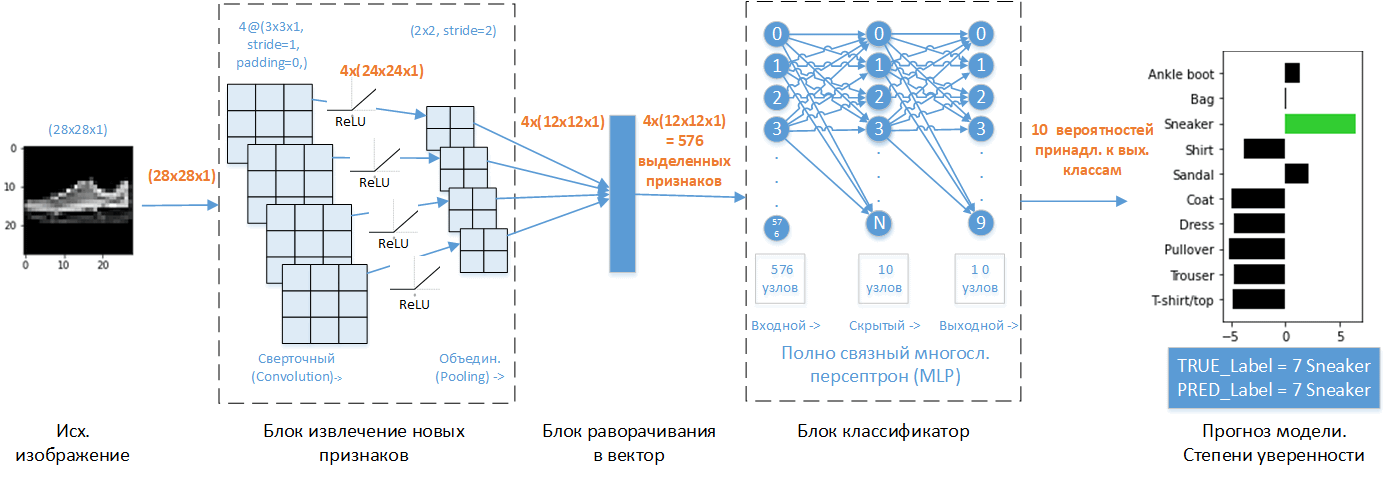

### Сверточный слой (Convolution)

Двумерная свертка (2D convolution) - операция преобразования группы исходных пикселей (признаки) в меньшую группу пикселей (признаков).

Для этого используется фильтр (ядро-матрицу, окно свёртки) размером FxF (пример 3x3). Фильтр содержит веса для математического преобразования значений исходных пикселей в один итоговый.
- Исходная матрица 5x5 = 255 признаков
- Выходная матрица 3x3 = 9 признаков

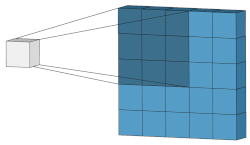

Исходное изображение (W, H, Ch) имеет параметры:
- ширина в пикселях - W
- высота в пикселях - H
- количество цветовых каналов - Ch

Фильтр (ядро-матрица, окно свёртки) размером (F, F, Ch) (пример 3x3x1) имеет параметры:
- Количество каналов цвета - Сh
- Размер фильтра (ядра-матрицы, окна свёртки) (kernel_size) - F
- Значения ячеек фильтра (ядра-матрицы, окна свёртки, kernel)
- Фильтр (F, F, 1) имеет (F * F * 1) + 1 весов (добавляется свободный член)

Ниже представлена демонстрация работы фильтра размером (3, 3, 1) = 3x3x1 с весами

      [0, 1, 2]
      [2, 2, 0]
      [0, 1, 2]

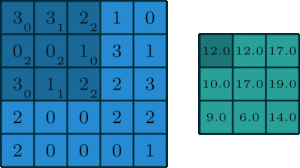

Каждый сверточный (k@FxFxCh) слой `tf.keras.layers.Conv2D` имеет параметры:
- filters: количество фильтров - k
- kernel_size: размер, единый для всех фильтров слоя (ядр-матриц, окон свёртки, kernel) - F
- stride: размер шага окна свёртки
- padding: размер обрамления в ситуации, когда шаг и размером окна свёртки выходит за границы изображения
- значение весов свёрточного слоя = числовые значения в фильтрах.
    
Запись формата k@FxFxCh или k@FxFx (пример 6@5x5x1) означает,
    
    что свёрточный слой имеет k фильтров,
    каждый из которых - (F, F, Ch).
    
Количество весов вычисляется как (k * (F * F * Ch)) + (1 * k) весов (последнее "+1*k" -- так как у каждого фильтра есть ещё параметр смещения bias)

#### Padding

Padding добавляет дополнительные пиксели (обрамляет) для того, чтобы крайние пиксели исходгой матрицы могли попасть в цент ядра-матрицы.

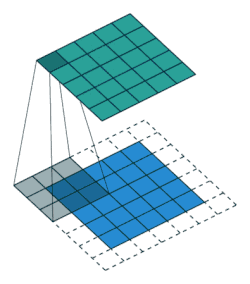

#### Striding

Striding - пропуск/перескакивание некоторых областей исходного изображения. Достигается увеличением шага перемещения ядра-матрицы.

- Шаг stride=1 означает, что берутся пролеты через пиксель, то есть по факту каждый пролет является стандартной сверткой.
- Шаг stride=2 означает, что пролеты совершаются через каждые два пикселя, пропуская все другие пролеты в процессе и уменьшая их количество примерно в 2 раза
- Шаг stride=3 означает пропуск 3-х пикселей, сокращая количество в 3 раза и т.д.

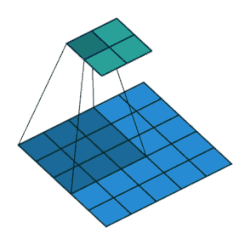

### Объединяющий слой (Пулинг, Pooling)

Объединяющий слой (также употребляются названия Subsampling, Cубдискритизирующий, Пулинг, Pooling), схож со светрочным, но __фильтр (ядро-матрица, окно свёртки, kernel) этого слоя не имеет весов__, а использует агрегатную функцию. Применяется для уменьшения размера исходных изображений (признаков), уменьшения шумов, выделение доминирующего признака.

Выделяют два типа агрегатных функций:
- выбор максимального значения (Max Pooling)   из части изображения, покрываемой фильтром.
- вычисление среднего значения (Average Pooling) из части изображения, покрываемой фильтром.

Каждый объединяющий слой, `tf.keras.layers.AveragePooling2D` и `tf.keras.layers.MaxPooling2D`, имеет параметры:
- pool_size: размер окна фильтра
- strides: шаг окна фильтра
- padding: тип обрамления

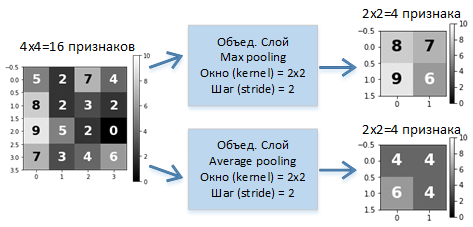

Размер выходного изображения после свёртки или объединения вычисляется по следующей формуле
    
    ((imgSize - filterSize + 2*padding) // stride) +1,

где:
  - imgSize: размер высоты или ширины исходного изображения, пикс.
  - filterSize: размер окна, пикс.
  - padding: размер обрамления, пикс.
  - stride:  размер шага окна свёртки

# Подготовительная часть. Демонстрация и проверка работы свёрточных слоёв

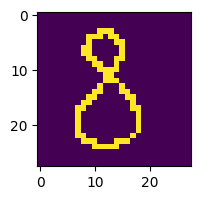

In [51]:
if not False: # not False = True
    # Создать прямым вводом значений
    imgNumpy = np.array(
      [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,  0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype='float')

elif False:
    # Выбрать изображение из исходного набора
    imgNumpy = test_images[10001].copy()
elif False:
    # Загрузить изображение с диска
    img = tf.keras.utils.load_img(
        path='./imgs/Путь_к_выбранному_изображению.расширение_файла', # Путь к файлу
        target_size=(28,28),   # Преобразовать к целевому размеру 28x28 пикселей
        color_mode='grayscale' # Преобразовать к черно-белому формату, 1 цветовой канал
    )
    imgNumpy = np.array(img, dtype='float')
    imgNumpy/=255.0 # Привести значения пикселей к диапазону [0.0, 1.0]

# Отобразить изображение
plt.figure(figsize=(2,2))
plt.imshow(imgNumpy)

In [52]:
imgNumpyForConv = imgNumpy.reshape(1,28,28,1) # shape= Размер передаваемого изображения = (batch_size, height, width, channels)

## Пример выполнения свёртки (Convolution)

In [53]:
convLayer = layers.Conv2D(
    filters     =  2 , # Два фильтра
    kernel_size =  ( 3, 3, ) ,
    strides     =  1 ,
)
# В виду програмный особенностей, для инициализации необходимо сымитировать передачу входных данных определённого размера
# shape= Размер передаваемого изображения = (batch_size, height, width, channels)
convLayer(  np.zeros(shape=(1,28,28,1)) );

In [54]:
#convLayer.get_weights()[0].shape
newWeights = np.zeros(((convLayer.kernel_size[0], convLayer.kernel_size[1], 1, convLayer.filters)))

# Установка значений весов окна свёртки НУЛЕВОГО фильтра
newWeights[:, :, :, 0] = np.array (
      # весовые коэфф. для окна (3х3)
      [
          [  [ 0.8 ],  [ 0.7 ], [ 0.9 ],  ], # Измените веса w_i окна свёртки, задайте значения от 0.0 до 1.0
          [  [ 0.9 ],  [ 0.8 ], [ 0.6 ],  ], # Измените веса w_i окна свёртки, задайте значения от 0.0 до 1.0
          [  [ 1 ],  [ 0.5 ], [ 0.7 ],  ],
      ]
)

# Установка значений весов окна свёртки ПЕРВОГО фильтра
newWeights[:, :, :, 1] = np.array (
      # весовые коэфф. для окна (3х3)
      [
          [  [ 1 ],  [ 1 ], [ 0.2 ],  ], # Измените веса w_i окна свёртки, задайте значения от 0.0 до 1.0
          [  [ 0.5 ],  [ 0.5 ], [ 0.5 ],  ], # Измените веса w_i окна свёртки, задайте значения от 0.0 до 1.0
          [  [ 0.3 ],  [ 0.9 ], [ 0.7 ],  ],
      ]
)

# Bias коэфф.
newBias = np.zeros(((2,)))
newBias;

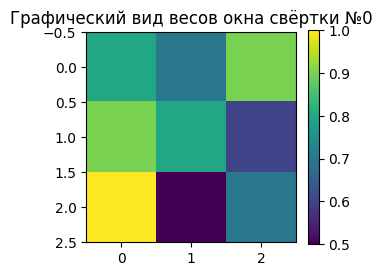

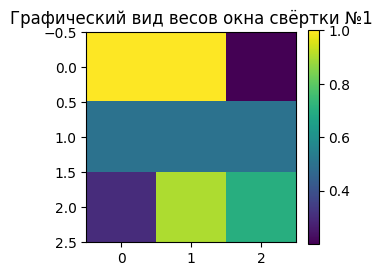

In [55]:
convLayer.set_weights([newWeights, newBias])

for filterNum in range ( 0, convLayer.filters):
  # Получить элементы соответвующие весам очередноо фильтра
  convWeight_forImshow = convLayer.weights[0][:, :, :, filterNum ]
  #print(convWeight_forImshow)

  # Представить окно свёртки графически
  plt.figure(figsize=(3,3))
  plt.imshow(convWeight_forImshow)
  plt.colorbar(fraction=0.046)
  plt.title(f"Графический вид весов окна свёртки №{filterNum}")
  plt.show()

In [56]:
# Применить свёрточный слой convLayer к изобржению imgNumpyForConv
imgNumpyAfterConv = convLayer( imgNumpyForConv )
imgNumpyAfterConv = imgNumpyAfterConv.numpy()  # получить матрицу ка объект библиотеки Numpy

print('Размер ВХодного  изображения: ', imgNumpy.shape, ', преобразовано к:', imgNumpyForConv.shape)
print(f"  Высота: {imgNumpyForConv.shape[1]}")
print(f"  Ширина: {imgNumpyForConv.shape[2]}")
print(f"  Кол-во: {imgNumpyForConv.shape[3]}")

print('Размер ВЫХодного изображения: ', imgNumpyAfterConv.shape)
print(f"  Высота: {imgNumpyAfterConv.shape[1]}")
print(f"  Ширина: {imgNumpyAfterConv.shape[2]}")
print(f"  Кол-во: {imgNumpyAfterConv.shape[3]}")

Размер ВХодного  изображения:  (28, 28) , преобразовано к: (1, 28, 28, 1)
  Высота: 28
  Ширина: 28
  Кол-во: 1
Размер ВЫХодного изображения:  (1, 26, 26, 2)
  Высота: 26
  Ширина: 26
  Кол-во: 2


(1, 26, 26)


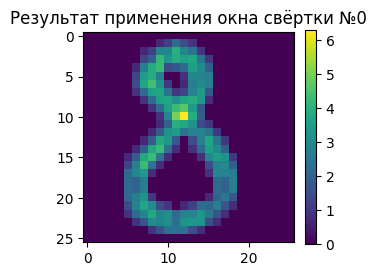

(1, 26, 26)


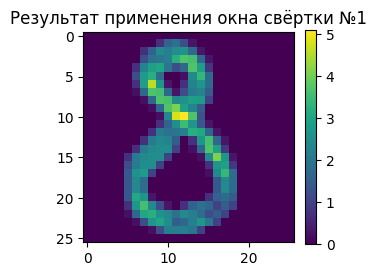

In [57]:
for filterNum in range (0, convLayer.filters):
  # Получить элементы соответвующие весам очередноо фильтра
  img_forImshow = imgNumpyAfterConv [:, :, :, filterNum]
  print (img_forImshow.shape)

  # Отобразить изображение
  plt.figure(figsize=(3,3))
  plt.imshow(img_forImshow.squeeze())
  plt.colorbar(fraction=0.046)
  plt.title(f"Результат применения окна свёртки №{filterNum}")

  plt.show()

## Пример выполнения объединения (Pooling)

In [59]:
poolLayer = layers.MaxPooling2D(
    pool_size = ( 3 , 3 ) ,
    strides   = 2,
)

In [60]:
imgNumpyAfterPooling = poolLayer( imgNumpyAfterConv )
imgNumpyAfterPooling = imgNumpyAfterPooling.numpy() # получить матрицу ка объект библиотеки Numpy

print('Размер ВХодного  изображения: ', imgNumpyAfterConv.shape, ', преобразовано к:', imgNumpyAfterConv.shape)
print(f"  Высота: {imgNumpyAfterConv.shape[1]}")
print(f"  Ширина: {imgNumpyAfterConv.shape[2]}")
print(f"  Кол-во: {imgNumpyAfterConv.shape[3]}")

print('Размер ВЫХодного изображения: ', imgNumpyAfterPooling.shape)
print(f"  Высота: {imgNumpyAfterPooling.shape[1]}")
print(f"  Ширина: {imgNumpyAfterPooling.shape[2]}")
print(f"  Кол-во: {imgNumpyAfterPooling.shape[3]}")

Размер ВХодного  изображения:  (1, 26, 26, 2) , преобразовано к: (1, 26, 26, 2)
  Высота: 26
  Ширина: 26
  Кол-во: 2
Размер ВЫХодного изображения:  (1, 12, 12, 2)
  Высота: 12
  Ширина: 12
  Кол-во: 2


(1, 12, 12)


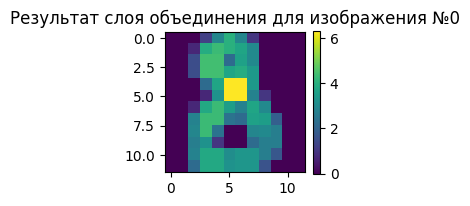

(1, 12, 12)


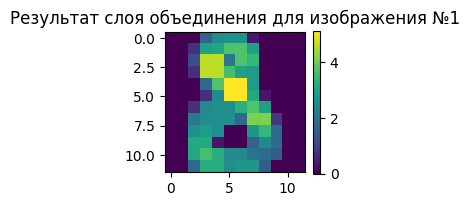

In [61]:
for filterNum in range (0, convLayer.filters):

  # Получить элементы соответвующие весам очередноо фильтра
  img_forImshow = imgNumpyAfterPooling [:, :, :, filterNum]
  print (img_forImshow.shape)

  # Отобразить изображение
  plt.figure(figsize=(2,2))
  plt.imshow(img_forImshow.squeeze())
  plt.colorbar(fraction=0.046)
  plt.title(f"Результат слоя объединения для изображения №{filterNum}")

  plt.show()

# Создание свёрточной НС. Создание структуры и выбор начальных параметров

In [316]:
# 2.1) Построение модели нейронной сети многослойного(Sequential) типа ----------------------------
model = tf.keras.Sequential()

# ДОБАВЛЕНИЕ НОВЫХ СЛОЁВ --------------------------
model.add( layers.Input( shape=(28,28,1) ))  # Входной слой, обеспечивает приём всех пикселей иходного изображения  shape=(height, width, colorChannels)

#========================== Блок выделения признаков ======================
model.add( layers.Conv2D      ( filters= 2, kernel_size=( 4, 4, ),  strides     = 1 ,  activation=activations.elu, ))
model.add( layers.MaxPooling2D( pool_size=( 2, 2, ),  strides     = 1 ,   ))

#========================== Блок классификации ============================
model.add( layers.Flatten() )                           # Слой для преобразования изображений в одномерный вектор

model.add( layers.Dense(units= 512, activation= activations.sigmoid, ))  # Скрытый полносвязный слой
model.add( layers.Dense(units= 256, activation= activations.sigmoid, ))  # Скрытый полносвязный слой
model.add( layers.Dense(units= 128, activation= activations.sigmoid, ))  # Скрытый полносвязный слой
model.add( layers.Dense(units= 64, activation= activations.sigmoid, ))  # Скрытый полносвязный слой
model.add( layers.Dense(units= 32, activation= activations.sigmoid, ))  # Скрытый полносвязный слой
model.add( layers.Dense(units= 16, activation= activations.sigmoid, ))  # Скрытый полносвязный слой

#========================== Выходной слой вычисления y_i ======================
model.add( layers.Dense(units= 10, activation= activations.softmax  )) # Выходной слой. Для классификации activation= softmax.



In [317]:
# 2.2) Функции потерь и функции оптимизации --------------------------------------------------------------------
fLoss      = losses.CategoricalCrossentropy()
fOptimizer = optimizers.Adam()
fMetric    = [ metrics.CategoricalAccuracy(),]

In [318]:
totalHistoryLossTrain=list() # Вспомогательный список для хранение полной истории обучения
totalHistoryLossTest =list() # Вспомогательный список для хранение полной истории обучения
globalEpochCounter = 1   # Общий счётчик эпох
fullFitTime           = 0.0 # Затраченное время для обучения модели

# 2.3) Инициализация модели --------------------------------------------------------------------
model.compile(
    loss      = fLoss,
    optimizer = fOptimizer,
    metrics   = [ fMetric ]
)
print("Вывод короткой информации о структуре НС")
model.summary()

Вывод короткой информации о структуре НС
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 25, 25, 2)         34        
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 24, 24, 2)        0         
 g2D)                                                            
                                                                 
 flatten_35 (Flatten)        (None, 1152)              0         
                                                                 
 dense_250 (Dense)           (None, 512)               590336    
                                                                 
 dense_251 (Dense)           (None, 256)               131328    
                                                                 
 dense_252 (Dense)           (None, 128)               32896     
            

### Обучение НС

In [319]:
startFitTime  =  time.time()
history = model.fit(
    x=train_images,   # Обучающие X,  размер (Кол-во_обучающих_образцов, 28, 28)
    y=train_labels,   # Обучающие Y,  размер (Кол-во_обучающих_образцов, Кол-во_классов)

    epochs= 9 ,  # Кол-во эпох обучения. Рекомендуемое значение: больше 1, менее 10

    batch_size=100, # Размер партии изображений внутри эпохи. Рекомендуемое значение от 32 до 1/20 части обучающей выборки

    verbose=1,      # уровень вывода инф. в процессе обучения
    validation_data=( # опционально - проверочные X и Y
        test_images, test_labels)
)
deltaFitTime = time.time() - startFitTime
fullFitTime+=deltaFitTime

# Сбор и дополнение полной истории обучения
totalHistoryLossTrain.extend(history.history['loss'])
if 'val_loss' in history.history.keys():
    totalHistoryLossTest.extend(history.history['val_loss'])

Epoch 1/9
600/600 [==============================] - 11s 17ms/step - loss: 1.6106 - categorical_accuracy: 0.4139 - val_loss: 1.1876 - val_categorical_accuracy: 0.6192
Epoch 2/9
600/600 [==============================] - 10s 17ms/step - loss: 0.9437 - categorical_accuracy: 0.6649 - val_loss: 0.7949 - val_categorical_accuracy: 0.7229
Epoch 3/9
600/600 [==============================] - 10s 17ms/step - loss: 0.6738 - categorical_accuracy: 0.7507 - val_loss: 0.6233 - val_categorical_accuracy: 0.7562
Epoch 4/9
600/600 [==============================] - 10s 16ms/step - loss: 0.5789 - categorical_accuracy: 0.7639 - val_loss: 0.5655 - val_categorical_accuracy: 0.7720
Epoch 5/9
600/600 [==============================] - 10s 17ms/step - loss: 0.5312 - categorical_accuracy: 0.7782 - val_loss: 0.5363 - val_categorical_accuracy: 0.7833
Epoch 6/9
600/600 [==============================] - 10s 17ms/step - loss: 0.4633 - categorical_accuracy: 0.8353 - val_loss: 0.4271 - val_categorical_accuracy: 0.863

In [320]:
print(f'Полное время на обучение модели, сек: {fullFitTime:.2f}')

Полное время на обучение модели, сек: 90.48


Text(0.5, 0, 'Эпохи обучения')

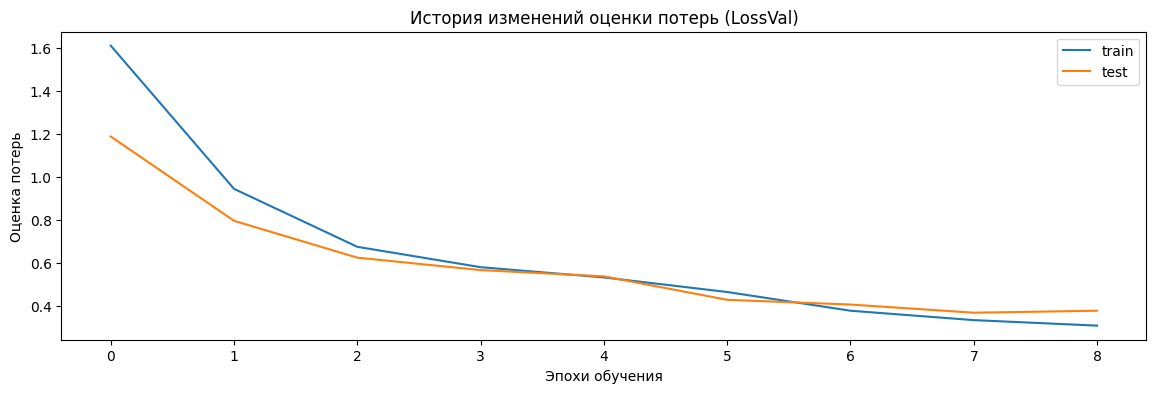

In [321]:
# После обучения ----------------------------------------------
# Отобразить график изменения оценки потерь по эпохам обучения
plt.figure(figsize=(14,4)) # создать полотно для рисования, figsize-размер в дюймах
plt.plot(totalHistoryLossTrain, label='train') # нанести на полотно график-линию
if 'val_loss' in history.history.keys():
    plt.plot(totalHistoryLossTest, label='test')
plt.legend()
plt.title("История изменений оценки потерь (LossVal)")
plt.ylabel("Оценка потерь")
plt.xlabel("Эпохи обучения")
###plt.ylim ( (0, 0.03) ) # область видимости для оси "Оценки потерь"

### Оценка общей точности

In [322]:
print('Вычисление ответов - вызов model.predict(X)')
y_pred_all_probability = model.predict(test_images)

Вычисление ответов - вызов model.predict(X)
313/313 [==============================] - 1s 4ms/step


In [323]:
y_pred_all_probability.shape

(10000, 10)

In [324]:
print(f'\nОтветы модели (вероятности принадлежности) на все предъявленные образцы (отображено для первых 10):')
pd.DataFrame(y_pred_all_probability).round(2)[:10]


Ответы модели (вероятности принадлежности) на все предъявленные образцы (отображено для первых 10):


,0,1,2,3,4,5,6,7,8,9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.99
1,0.00,0.00,0.91,0.00,0.03,0.00,0.06,0.00,0.00,0.00
2,0.01,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.01,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.09,0.00,0.08,0.02,0.03,0.00,0.78,0.00,0.01,0.00
5,0.01,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.06,0.01,0.89,0.00,0.04,0.00,0.00,0.00
7,0.06,0.00,0.08,0.01,0.06,0.00,0.78,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.99,0.00,0.01,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.98,0.00,0.01


In [325]:
print(f'\nВычисленные метки классов y_pred_all:\nПолучить из вероятностей заключения - номер класса с максимальной вероятностью (отображено для первых 10 изображений)')
y_pred_all_labels = tf.argmax(y_pred_all_probability, axis=1)
print('Вычисленые метки классов для первых ')
y_pred_all_labels[:10]


Вычисленные метки классов y_pred_all:
Получить из вероятностей заключения - номер класса с максимальной вероятностью (отображено для первых 10 изображений)
Вычисленые метки классов для первых 


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=int64)>

In [326]:
test_labels[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [327]:
print(f'\nОжидаемые метки классов y_train:\nПолучить из вероятностей заключения - номер класса с максимальной вероятностью (отображено для первых 10 изображений)')
y_test_all_labels = tf.argmax(test_labels, axis=1)
y_test_all_labels[:10]


Ожидаемые метки классов y_train:
Получить из вероятностей заключения - номер класса с максимальной вероятностью (отображено для первых 10 изображений)


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=int64)>

Ожидаемые/проверочные метки классов:
 tf.Tensor([9 2 1 ... 8 1 5], shape=(10000,), dtype=int64) 

Вычисленные метки классов:
 tf.Tensor([9 2 1 ... 8 1 7], shape=(10000,), dtype=int64) 

[[752   0   6  22   7   1 202   0  10   0]
 [  1 967   0  25   2   0   4   0   1   0]
 [  8   0 738   7 182   0  61   0   4   0]
 [  9   5   3 894  54   0  30   0   5   0]
 [  0   1  27  14 933   0  21   0   4   0]
 [  0   0   0   1   0 958   0  30   1  10]
 [ 63   1  80  31 192   0 623   0  10   0]
 [  0   0   0   0   0  13   0 963   1  23]
 [  0   0   0   5   7   1   7   2 977   1]
 [  0   0   0   0   0   7   0  34   1 958]]


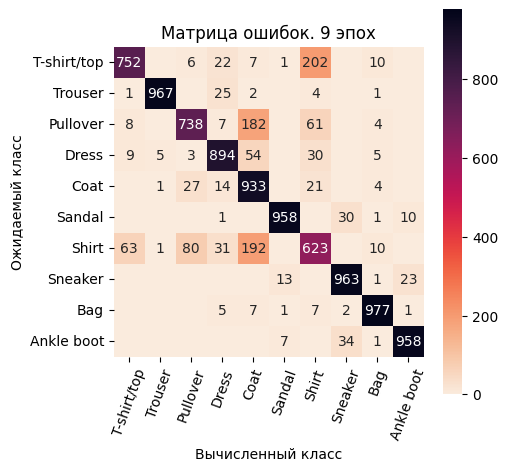

In [328]:
print('Ожидаемые/проверочные метки классов:\n', y_test_all_labels,'\n')
print('Вычисленные метки классов:\n',           y_pred_all_labels,'\n')

calcAndPlotConfusionMatrix (
    y_test_all_labels, # ожидаемымые ответы
    y_pred_all_labels, # вычисленные ответы
    class_names        # список названий классов
)

Ожидаемые/проверочные метки классов:
 tf.Tensor([9 2 1 ... 8 1 5], shape=(10000,), dtype=int64) 

Вычисленные метки классов:
 tf.Tensor([9 2 1 ... 8 1 7], shape=(10000,), dtype=int64) 

[[752   0   6  22   7   1 202   0  10   0]
 [  1 967   0  25   2   0   4   0   1   0]
 [  8   0 738   7 182   0  61   0   4   0]
 [  9   5   3 894  54   0  30   0   5   0]
 [  0   1  27  14 933   0  21   0   4   0]
 [  0   0   0   1   0 958   0  30   1  10]
 [ 63   1  80  31 192   0 623   0  10   0]
 [  0   0   0   0   0  13   0 963   1  23]
 [  0   0   0   5   7   1   7   2 977   1]
 [  0   0   0   0   0   7   0  34   1 958]]


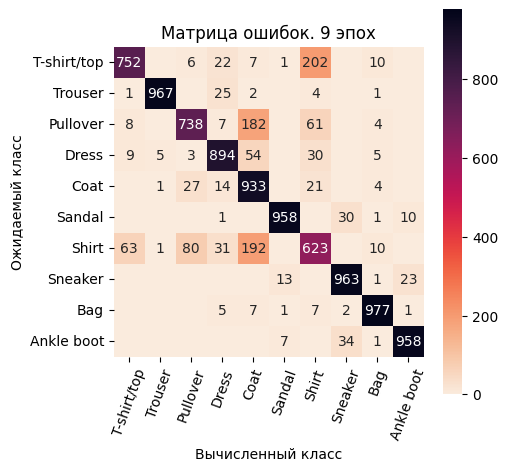

In [329]:
print('Ожидаемые/проверочные метки классов:\n', y_test_all_labels,'\n')
print('Вычисленные метки классов:\n',           y_pred_all_labels,'\n')

calcAndPlotConfusionMatrix (
    y_test_all_labels, # ожидаемымые ответы
    y_pred_all_labels, # вычисленные ответы
    class_names        # список названий классов
)

In [330]:
print(
    classification_report(
      y_true= y_test_all_labels, # ожидаемымые ответы
      y_pred= y_pred_all_labels, # вычисленные ответы
      target_names=class_names,  # список названий классов
))

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.75      0.82      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.86      0.74      0.80      1000
       Dress       0.89      0.89      0.89      1000
        Coat       0.68      0.93      0.79      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.66      0.62      0.64      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Оценка одиночного изображения

In [331]:
mask = np.not_equal(
    y_test_all_labels.numpy(),
    y_pred_all_labels.numpy())
indexesAll = np.arange(y_test_all_labels.shape[0])
indexesWrongPredict = indexesAll[mask]
print(f'Кол-во ошибочных ответов модели: {indexesWrongPredict.shape[0]}\n')

print('Образцы с ошибочно вычисленным классом:')
print('Изобр. №| Истинный       | Вычисленный')
for index in indexesWrongPredict:
  yiTrue = y_test_all_labels.numpy()[index]
  yiPred = y_pred_all_labels.numpy()[index]
  print(f'- {index:>5} | {yiTrue} {class_names[yiTrue]:>12} | {yiPred}  {class_names[yiTrue]:>12}')
  break

Кол-во ошибочных ответов модели: 1237

Образцы с ошибочно вычисленным классом:
Изобр. №| Истинный       | Вычисленный
-    23 | 9   Ankle boot | 5    Ankle boot


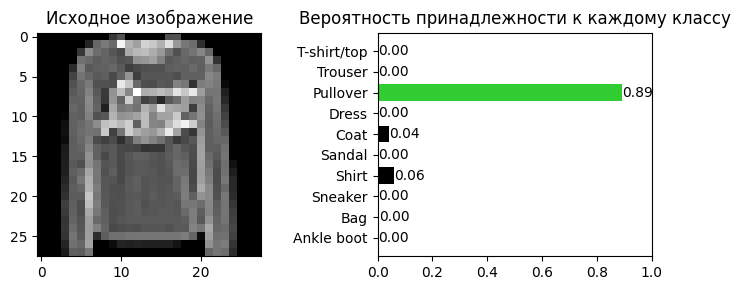

Класс (метка):
  - Истинный    TRUE_Label = 2 Pullover
  - Вычисленный PRED_Label = 2 Pullover
Вероятность принадлежности к каждому классу:
  - Класс_0  T-shirt/top :  0.1%
  - Класс_1      Trouser :  0.0%
  - Класс_2     Pullover : 89.3%
  - Класс_3        Dress :  0.0%
  - Класс_4         Coat :  4.1%
  - Класс_5       Sandal :  0.0%
  - Класс_6        Shirt :  6.1%
  - Класс_7      Sneaker :  0.0%
  - Класс_8          Bag :  0.4%
  - Класс_9   Ankle boot :  0.0%


In [342]:
# Выбор номера проверочного изображения
img_index = 520
checkPrediction(  model,  test_images, test_labels, img_index)